In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dataclasses import dataclass
from pylab import *

In [2]:
#read the on sensor log data

@dataclass
class ReadData:
    gyro: np.ndarray
    acce: np.ndarray   

def read_data_file(data_filename, rate=10):
    gyro = []
    acce = []
    
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.split('|')

        if line_data[1] == 'LSM6DSO Gyroscope Sensor':
            temp = np.fromstring(line_data[2][1:-1], dtype=np.float, sep=',')
            gyro.append([int(line_data[3]), temp[0], temp[1], temp[2]])
            continue
        if line_data[1] == 'LSM6DSO Acceleration Sensor':
            temp = np.fromstring(line_data[2][1:-1], dtype=np.float, sep=',')
            acce.append([int(line_data[3]), temp[0], temp[1], temp[2]])
            continue
            
    gyro = np.array(gyro)        
    acce = np.array(acce)
    
    tmin = max(min(gyro[:,0]),min(acce[:,0]))
    tmax = min(max(gyro[:,0]),max(acce[:,0]))
    tvec = np.arange(int(tmin) , int(tmax) , rate)
    
    gyrx = interp1d(gyro[:,0],gyro[:,1])(tvec)
    gyry = interp1d(gyro[:,0],gyro[:,2])(tvec)
    gyrz = interp1d(gyro[:,0],gyro[:,3])(tvec)
    gyro = np.concatenate(([tvec], [gyrx], [gyry], [gyrz]), axis=0)
    gyro = np.transpose(gyro)
    
    accx = interp1d(acce[:,0],acce[:,1])(tvec)
    accy = interp1d(acce[:,0],acce[:,2])(tvec)
    accz = interp1d(acce[:,0],acce[:,3])(tvec)
    acce = np.concatenate(([tvec], [accx], [accy], [accz]), axis=0)
    acce = np.transpose(acce)
    
    return ReadData(gyro,acce)
               
def removeNsecond(data,frequency,N):
    for i in range(0,N*frequency):
        data = np.delete(data,0,0)
    return data

In [3]:
#plot wkt by matplotlib

def plot_linestring_from_WKT(wktstring):

    sp = wktstring.replace(',','').replace(')',' ').replace('(','').split(' ')
   
#     print(sp);
    if sp[0] == "LINESTRING":
        #look for elevationlevel and use matching indices:
        if float(sp[3]) < 5000: 
            x1 = float(sp[1])
            y1 = float(sp[2])
            x2 = float(sp[4])
            y2 = float(sp[5])           
        else:
            x1 = float(sp[1])
            y1 = float(sp[2])
            x2 = float(sp[3])
            y2 = float(sp[4])
        
        plt.plot([x1, x2], [y1, y2],
                 linewidth=1.0,
                 color='b',
                 alpha=0.5)
        plt.axis('tight');
        
def plot_wkt(path): #'dir/hcu4og_trans.wkt'
    f = open(path,'r');     #https://www.digitalocean.com/community/tutorials/how-to-handle-plain-text-files-in-python-3
    lines = f.readlines();
    f.close()
    for wkt in lines:
        plot_linestring_from_WKT(wkt)       

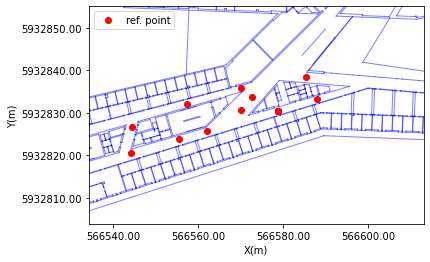

In [4]:
if __name__ == '__main__':
    
    # Read the sensor data from the log
    path_datas = read_data_file('SensorLog/log.txt')
    acc = removeNsecond(path_datas.acce,100,2) 
    gyr = removeNsecond(path_datas.gyro,100,2) 

#     np.savetxt("SensorLog/acc.csv", acc, delimiter=" ")
#     np.savetxt("SensorLog/gyr.csv", gyr, delimiter=" ")

    # Read the ground Truth and 5G simulation result
    simulated_5g = np.genfromtxt('SimulationResults/5Gsimulattion_many.csv', delimiter=' ', skip_header=0)
    ref_points = np.genfromtxt('refpoints.csv', delimiter=' ', skip_header=0)
    
    # Read the Floor Plan and routinggraph
    floor_plan = 'FloorPlan/hcu4og_trans.wkt'
    rout_graph = 'FloorPlan/hcu4og_routing.wkt'

    # Plot maps
    plt.show()
    plt.plot(ref_points[:,1],ref_points[:,2],'o',color = 'r',label = 'ref. point')
    plot_wkt(floor_plan)
    locs,labels = xticks()
    xticks(locs, map(lambda x: "%.2f" % x, locs))
    locs,labels = yticks()
    yticks(locs, map(lambda x: "%.2f" % x, locs)) 
    plt.axis('equal')
    plt.xlim(min(ref_points[:,1])-10,max(ref_points[:,1])+25)
    plt.ylim(min(ref_points[:,2]),max(ref_points[:,2]))
    plt.xlabel('X(m)') 
    plt.ylabel('Y(m)')
    plt.legend()